# Importing Data for Preprocessing

In [1]:
import os 
import pandas as pd

In [2]:
PATH_STROKES_ANNOTATIONS = os.path.join('Annotations', 'stroke_annotations.csv') 
PATH_STROKES_IMGS = os.path.join('data','Strokes','manual')  # Raw data directory 
PATH_CONVERTED = os.path.join('data','Strokes','converted')  # Processed grayscale data directory 

In [3]:
df = pd.read_csv(PATH_STROKES_ANNOTATIONS) 
df = df[df['CLASS'] != 'backhand clear']
df.head() 

,IMAGE,CLASS
0,1,smash
1,2,net drop return
2,3,net drop return
3,4,net drop return
4,5,defense


In [4]:
df.shape

(201, 2)

In [5]:
df['IMAGE'] = [os.path.join(PATH_CONVERTED, str(img)+'.png') for img in df['IMAGE']] 
df.head() 

,IMAGE,CLASS
0,data\Strokes\converted\1.png,smash
1,data\Strokes\converted\2.png,net drop return
2,data\Strokes\converted\3.png,net drop return
3,data\Strokes\converted\4.png,net drop return
4,data\Strokes\converted\5.png,defense


In [6]:
df['CLASS'].unique()

array(['smash', 'net drop return', 'defense', 'smash '], dtype=object)

In [10]:
df['CLASS'] = df['CLASS'].str.strip()

In [11]:
df['CLASS'].unique()

array(['smash', 'net drop return', 'defense'], dtype=object)

# Image Preprocessing (Run only once)

Since all the captured images are a different dimension, the images need to be brought down to the same size in order for the model to be configured properly. Also, the colors in the images don't matter so it should speed up the training process with 1 color channel compared to 3 if we go with grayscale images.

In [6]:
from PIL import Image, ImageOps
import os, sys

In [7]:
# Grayscaling and Resizing

def preprocess(source, dest): 
    dirs = os.listdir(source)
    for item in dirs:  
        if os.path.isfile(os.path.join(source,item)):
            im = Image.open(os.path.join(source,item))
            resize_im = im.resize((85,140), Image.ANTIALIAS)
            new_im = ImageOps.grayscale(resize_im)
            filename = os.path.join(dest, item)
            new_im.save(filename, 'PNG', quality=90)

In [8]:
PATH_CONVERTED = os.path.join('data','Strokes','converted')

preprocess(PATH_STROKES_IMGS, PATH_CONVERTED) 

<ipython-input-7-9eccb1d57c70>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resize_im = im.resize((85,140), Image.ANTIALIAS)


# Dataset Creation

In [12]:
from skimage import io 
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 

In [13]:
urls = df['IMAGE'] 
X = [] 

le = preprocessing.LabelEncoder()
le.fit(df['CLASS'])
df['categorical_label'] = le.transform(df['CLASS'])

y = np.array(df['categorical_label'])
y = tf.keras.utils.to_categorical(y ,num_classes=3)  

for url in urls: 
    img = io.imread(url, as_gray = True) 
    img = img.reshape([img.shape[0],img.shape[1],1])
    X.append(img) 
    
df.head() 

,IMAGE,CLASS,categorical_label
0,data\Strokes\converted\1.png,smash,2
1,data\Strokes\converted\2.png,net drop return,1
2,data\Strokes\converted\3.png,net drop return,1
3,data\Strokes\converted\4.png,net drop return,1
4,data\Strokes\converted\5.png,defense,0


### Testing with different lengths of datasets

In [14]:
X_min = np.array(X[0:60]) # min dataset of size 60
X_mid = np.array(X[0:120]) # mid dataset of size 120
X_max = np.array(X[0:201]) # max dataset of size 201

In [15]:
y_min = y[0:60]
y_mid = y[0:120]
y_max = y[0:201]

In [16]:
X_min.shape

(60, 140, 85, 1)

In [17]:
y_min.shape 

(60, 3)

# Train/Test Split

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### For X_min,y_min

In [13]:
X_min_train, X_min_test, y_min_train, y_min_test = train_test_split(X_min, y_min, test_size = 0.3, random_state = 3) 

### For X_mid,y_mid

In [14]:
X_mid_train, X_mid_test, y_mid_train, y_mid_test = train_test_split(X_mid, y_mid, test_size = 0.3, random_state = 3) 

### For X_max,y_max

In [19]:
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max, y_max, test_size = 0.3, random_state = 3) 

# Convolutional Neural Networks

## A) For X_min, y_min

### Model Training

In [24]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=0) 
model = tf.keras.Sequential([
    # Add Convo Layers here 
    tf.keras.layers.Conv2D(filters=30, kernel_size=3, activation='relu', input_shape = [X_min.shape[1],X_min.shape[2],1]),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape = [X_min.shape[1],X_min.shape[2],1]),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 
    # Add ANN here 
    tf.keras.layers.Flatten() ,
    tf.keras.layers.Dense(units = 128, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 1
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 64, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 2
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units = 3, activation= 'softmax', kernel_initializer= xavier_init)  # Output Layer 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

### Validation Accuracy - 61%

In [26]:
hist_min = model.fit(
    X_min_train, y_min_train, 
    batch_size=6, 
    epochs = 20, 
    verbose = 2, 
    validation_data=(X_min_test, y_min_test) 
) 

Epoch 1/20
7/7 - 2s - loss: 51.4193 - accuracy: 0.3571 - val_loss: 10.9575 - val_accuracy: 0.1111 - 2s/epoch - 272ms/step
Epoch 2/20
7/7 - 0s - loss: 17.1575 - accuracy: 0.4048 - val_loss: 1.3481 - val_accuracy: 0.2222 - 275ms/epoch - 39ms/step
Epoch 3/20
7/7 - 0s - loss: 1.1211 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.2222 - 299ms/epoch - 43ms/step
Epoch 4/20
7/7 - 0s - loss: 0.8576 - accuracy: 0.6667 - val_loss: 1.0065 - val_accuracy: 0.5000 - 306ms/epoch - 44ms/step
Epoch 5/20
7/7 - 0s - loss: 0.6653 - accuracy: 0.7381 - val_loss: 1.0691 - val_accuracy: 0.5556 - 316ms/epoch - 45ms/step
Epoch 6/20
7/7 - 0s - loss: 0.4102 - accuracy: 0.8095 - val_loss: 1.0812 - val_accuracy: 0.6111 - 292ms/epoch - 42ms/step
Epoch 7/20
7/7 - 0s - loss: 0.2092 - accuracy: 0.9524 - val_loss: 1.8118 - val_accuracy: 0.5556 - 291ms/epoch - 42ms/step
Epoch 8/20
7/7 - 0s - loss: 0.1902 - accuracy: 0.9762 - val_loss: 0.9314 - val_accuracy: 0.6667 - 293ms/epoch - 42ms/step
Epoch 9/20
7/7 - 0s - l

### Save model

In [42]:
model.save(os.path.join('models','stroke_min.h5')) 

### Load Saved Model

In [18]:
model_min = tf.keras.models.load_model(os.path.join('models','stroke_min.h5'))

### Cross Entropy Loss Graph

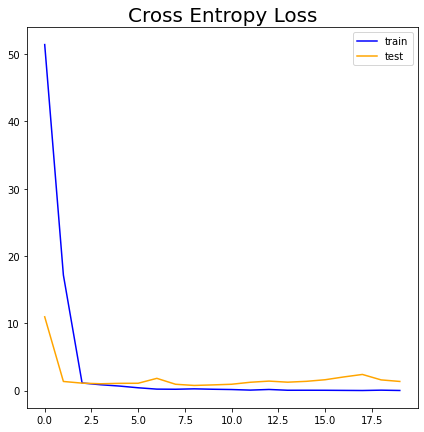

In [32]:
plt.figure(figsize = (7,7))
plt.title('Cross Entropy Loss', fontdict={'fontsize':20})
plt.plot(hist_min.history['loss'], color='blue', label='train')
plt.plot(hist_min.history['val_loss'], color='orange', label='test')
plt.legend()
plt.show()

### Accuracy Graph

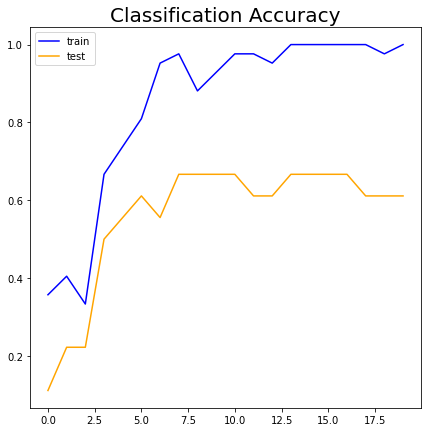

In [33]:
plt.figure(figsize = (7,7))
plt.title('Classification Accuracy', fontdict={'fontsize':20})
plt.plot(hist_min.history['accuracy'], color='blue', label='train')
plt.plot(hist_min.history['val_accuracy'], color='orange', label='test')
plt.legend()
plt.show()

### Confusion Matrix

1/1 [==============================] - 0s 53ms/step


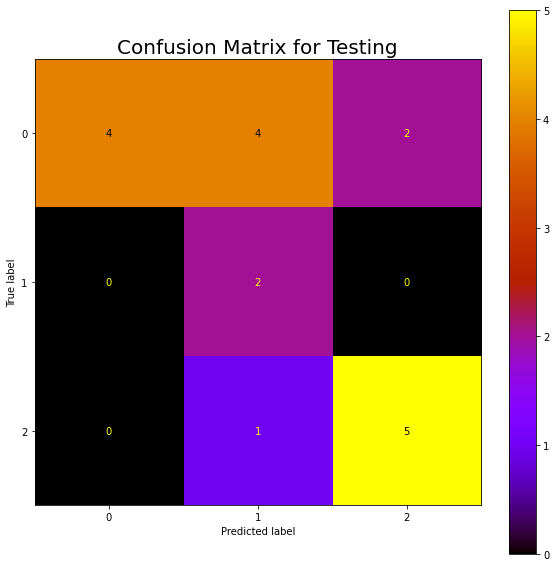

In [22]:
# For Testing Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

labels = [y.argmax() for y in y_min_test] 

predictions = [] 
for i in range(len(X_min_test)): 
    img = X_min_test[i].reshape([1,X_min.shape[1],X_min.shape[2],1])
    predictions.append(model_min.predict(img).argmax())  
    
cm = confusion_matrix(labels,predictions)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix for Testing', fontdict={'fontsize':20})
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(cmap = 'gnuplot',ax = ax)

plt.show()

1/1 [==============================] - 0s 93ms/step


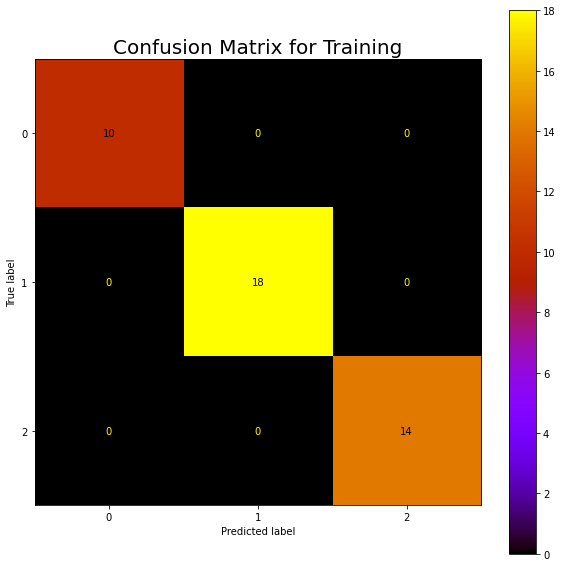

In [23]:
# For Training Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

labels = [y.argmax() for y in y_min_train] 

predictions = [] 
for i in range(len(X_min_train)): 
    img = X_min_train[i].reshape([1,X_min.shape[1],X_min.shape[2],1])
    predictions.append(model_min.predict(img).argmax())  
    
cm = confusion_matrix(labels,predictions)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix for Training', fontdict={'fontsize':20})
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(cmap = 'gnuplot',ax = ax)

plt.show()

## B) For X_mid, y_mid

### Model Training

In [45]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=0) 
model = tf.keras.Sequential([
    # Add Convo Layers here 
    tf.keras.layers.Conv2D(filters=30, kernel_size=3, activation='relu', input_shape = [X_mid.shape[1],X_mid.shape[2],1]),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape = [X_mid.shape[1],X_mid.shape[2],1]),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 
    # Add ANN here 
    tf.keras.layers.Flatten() ,
    tf.keras.layers.Dense(units = 128, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 1
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 64, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 2
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units = 3, activation= 'softmax', kernel_initializer= xavier_init)  # Output Layer 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

### Validation Accuracy - 77%

In [46]:
hist_mid = model.fit(
    X_mid_train, y_mid_train, 
    batch_size=6, 
    epochs = 20, 
    verbose = 2, 
    validation_data=(X_mid_test, y_mid_test) 
) 

Epoch 1/20
14/14 - 2s - loss: 5.8464 - accuracy: 0.4405 - val_loss: 1.1482 - val_accuracy: 0.3889 - 2s/epoch - 110ms/step
Epoch 2/20
14/14 - 1s - loss: 0.9246 - accuracy: 0.6071 - val_loss: 0.9275 - val_accuracy: 0.6111 - 539ms/epoch - 38ms/step
Epoch 3/20
14/14 - 1s - loss: 0.5135 - accuracy: 0.8095 - val_loss: 0.6830 - val_accuracy: 0.7500 - 545ms/epoch - 39ms/step
Epoch 4/20
14/14 - 1s - loss: 0.1840 - accuracy: 0.9286 - val_loss: 0.5707 - val_accuracy: 0.8611 - 556ms/epoch - 40ms/step
Epoch 5/20
14/14 - 1s - loss: 0.1422 - accuracy: 0.9405 - val_loss: 0.8147 - val_accuracy: 0.6389 - 563ms/epoch - 40ms/step
Epoch 6/20
14/14 - 1s - loss: 0.0979 - accuracy: 0.9881 - val_loss: 0.6602 - val_accuracy: 0.8611 - 545ms/epoch - 39ms/step
Epoch 7/20
14/14 - 1s - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.9013 - val_accuracy: 0.7500 - 552ms/epoch - 39ms/step
Epoch 8/20
14/14 - 1s - loss: 0.1247 - accuracy: 0.9881 - val_loss: 0.8644 - val_accuracy: 0.7778 - 621ms/epoch - 44ms/step
Epoch 9/20

### Save model

In [52]:
model.save(os.path.join('models','stroke_mid.h5')) 

### Load Saved Model

In [24]:
model_mid = tf.keras.models.load_model(os.path.join('models','stroke_mid.h5'))

### Cross Entropy Loss Graph

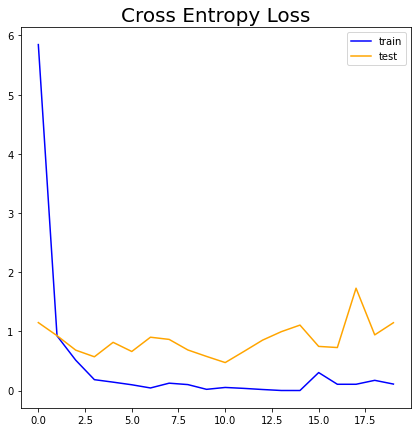

In [47]:
plt.figure(figsize = (7,7))
plt.title('Cross Entropy Loss', fontdict={'fontsize':20})
plt.plot(hist_mid.history['loss'], color='blue', label='train')
plt.plot(hist_mid.history['val_loss'], color='orange', label='test')
plt.legend()
plt.show()

### Accuracy Graph

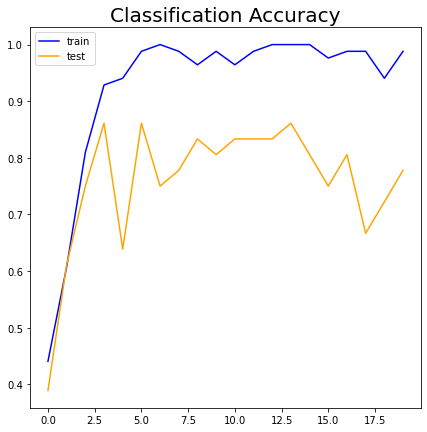

In [48]:
plt.figure(figsize = (7,7))
plt.title('Classification Accuracy', fontdict={'fontsize':20})
plt.plot(hist_mid.history['accuracy'], color='blue', label='train')
plt.plot(hist_mid.history['val_accuracy'], color='orange', label='test')
plt.legend()
plt.show()

### Confusion Matrix

1/1 [==============================] - 0s 50ms/step


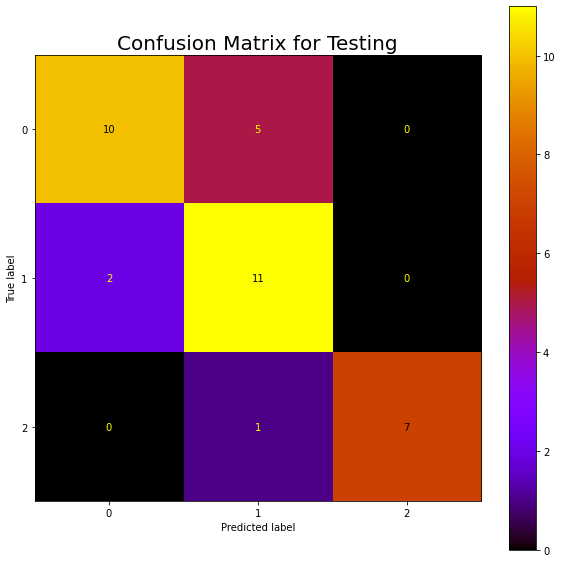

In [25]:
# For Testing Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

labels = [y.argmax() for y in y_mid_test] 

predictions = [] 
for i in range(len(X_mid_test)): 
    img = X_mid_test[i].reshape([1,X_mid.shape[1],X_mid.shape[2],1])
    predictions.append(model_mid.predict(img).argmax())  
    
cm = confusion_matrix(labels,predictions)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix for Testing', fontdict={'fontsize':20})
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(cmap = 'gnuplot',ax = ax)

plt.show()

1/1 [==============================] - 0s 87ms/step


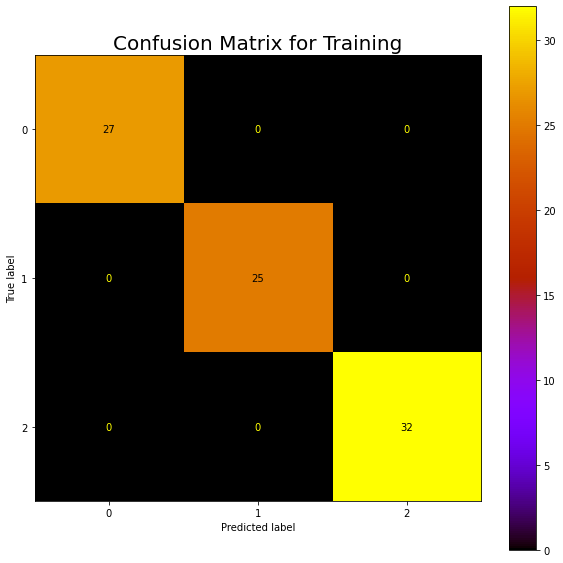

In [26]:
# For Training Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

labels = [y.argmax() for y in y_mid_train] 

predictions = [] 
for i in range(len(X_mid_train)): 
    img = X_mid_train[i].reshape([1,X_mid.shape[1],X_mid.shape[2],1])
    predictions.append(model_mid.predict(img).argmax())  
    
cm = confusion_matrix(labels,predictions)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix for Training', fontdict={'fontsize':20})
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(cmap = 'gnuplot',ax = ax)

plt.show()

## C) For X_max, y_max

### Model Training

In [26]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=0) 
model = tf.keras.Sequential([
    # Add Convo Layers here 
    tf.keras.layers.Conv2D(filters=30, kernel_size=3, activation='relu', input_shape = [X_max.shape[1],X_max.shape[2],1]),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape = [X_max.shape[1],X_max.shape[2],1]),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 
    # Add ANN here 
    tf.keras.layers.Flatten() ,
    tf.keras.layers.Dense(units = 128, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 1
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 64, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 2
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units = 3, activation= 'softmax', kernel_initializer= xavier_init)  # Output Layer 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

### Validation Accuracy - 81%

In [27]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [28]:
hist_max = model.fit(
    X_max_train, y_max_train, 
    batch_size=6, 
    epochs = 30, 
    verbose = 2,
    callbacks=[early_stop],
    validation_data=(X_max_test, y_max_test) 
) 

Epoch 1/30
24/24 - 2s - loss: 21.1479 - accuracy: 0.3643 - val_loss: 1.0301 - val_accuracy: 0.4426 - 2s/epoch - 89ms/step
Epoch 2/30
24/24 - 1s - loss: 0.8829 - accuracy: 0.5857 - val_loss: 0.7747 - val_accuracy: 0.6230 - 989ms/epoch - 41ms/step
Epoch 3/30
24/24 - 1s - loss: 0.4943 - accuracy: 0.8000 - val_loss: 0.6574 - val_accuracy: 0.6885 - 1s/epoch - 42ms/step
Epoch 4/30
24/24 - 1s - loss: 0.3717 - accuracy: 0.8571 - val_loss: 0.5851 - val_accuracy: 0.7377 - 1000ms/epoch - 42ms/step
Epoch 5/30
24/24 - 1s - loss: 0.1694 - accuracy: 0.9571 - val_loss: 0.5685 - val_accuracy: 0.8525 - 1s/epoch - 42ms/step
Epoch 6/30
24/24 - 1s - loss: 0.1324 - accuracy: 0.9500 - val_loss: 0.6579 - val_accuracy: 0.7541 - 1s/epoch - 42ms/step
Epoch 7/30
24/24 - 1s - loss: 0.1151 - accuracy: 0.9571 - val_loss: 0.8913 - val_accuracy: 0.7213 - 1s/epoch - 42ms/step
Epoch 8/30
24/24 - 1s - loss: 0.0993 - accuracy: 0.9571 - val_loss: 1.2270 - val_accuracy: 0.7213 - 987ms/epoch - 41ms/step
Epoch 9/30
24/24 - 1s

### Save model

In [29]:
model.save(os.path.join('models','stroke_max.h5')) 

### Load Saved Model

In [30]:
model_max = tf.keras.models.load_model(os.path.join('models','stroke_max.h5'))

### Cross Entropy Loss Graph

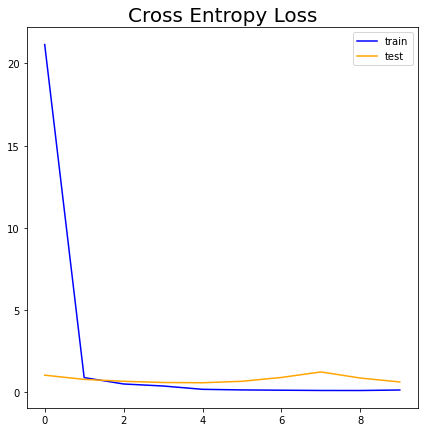

In [31]:
plt.figure(figsize = (7,7))
plt.title('Cross Entropy Loss', fontdict={'fontsize':20})
plt.plot(hist_max.history['loss'], color='blue', label='train')
plt.plot(hist_max.history['val_loss'], color='orange', label='test')
plt.legend()
plt.show()

### Accuracy Graph

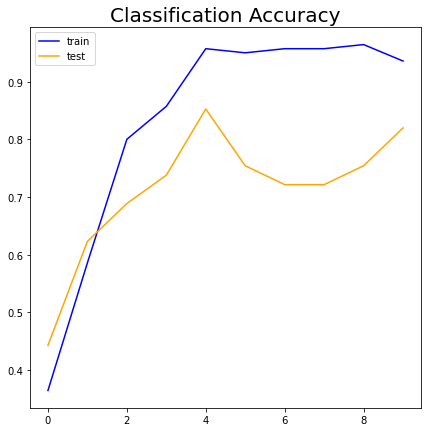

In [32]:
plt.figure(figsize = (7,7))
plt.title('Classification Accuracy', fontdict={'fontsize':20})
plt.plot(hist_max.history['accuracy'], color='blue', label='train')
plt.plot(hist_max.history['val_accuracy'], color='orange', label='test')
plt.legend()
plt.show()

### Confusion Matrix

1/1 [==============================] - 0s 27ms/step


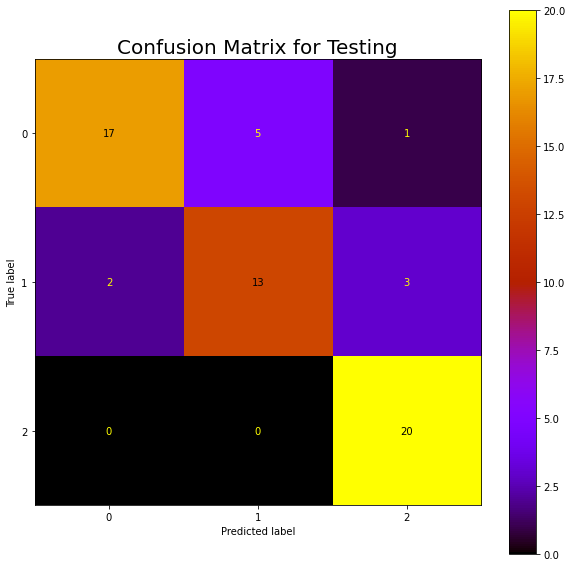

In [34]:
# For Testing Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

labels = [y.argmax() for y in y_max_test] 

predictions = [] 
for i in range(len(X_max_test)): 
    img = X_max_test[i].reshape([1,X_max.shape[1],X_max.shape[2],1])
    predictions.append(model_max.predict(img).argmax())  
    
cm = confusion_matrix(labels,predictions)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix for Testing', fontdict={'fontsize':20})
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(cmap = 'gnuplot',ax = ax)

plt.show()

1/1 [==============================] - 0s 115ms/step


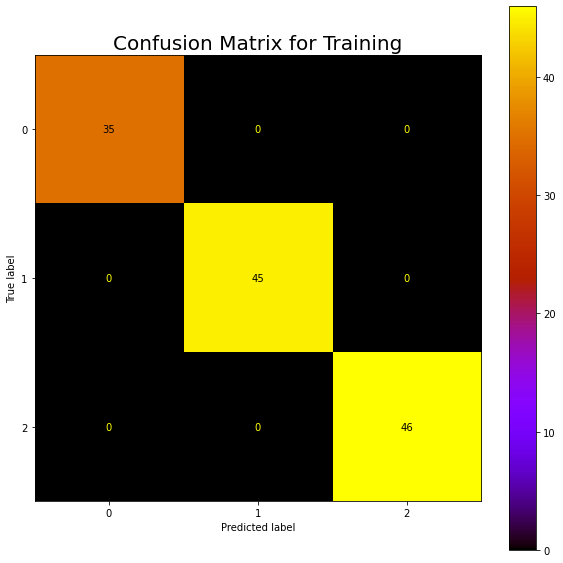

In [31]:
# For Training Dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

labels = [y.argmax() for y in y_max_train] 

predictions = [] 
for i in range(len(X_max_train)): 
    img = X_max_train[i].reshape([1,X_max.shape[1],X_max.shape[2],1])
    predictions.append(model_max.predict(img).argmax())  
    
cm = confusion_matrix(labels,predictions)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix for Training', fontdict={'fontsize':20})
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(cmap = 'gnuplot',ax = ax)

plt.show()

# CNN Model Prediction Results

In [35]:
le.inverse_transform([0,1,2])

array(['defense', 'net drop return', 'smash'], dtype=object)

In [36]:
X_max_test[1].shape

(140, 85, 1)

1/1 [==============================] - 0s 24ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 23ms/step
Probabilities of prediction:  [[0.47047442 0.5103138  0.0192118 ]]


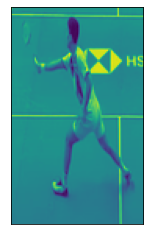

------------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 27ms/step
Probabilities of prediction:  [[9.9916756e-01 4.2379653e-04 4.0865366e-04]]


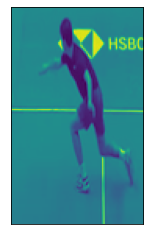

------------------------------------------------------------------
1/1 [==============================] - 0s 33ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 38ms/step
Probabilities of prediction:  [[0.26013908 0.3237003  0.41616067]]


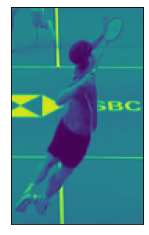

------------------------------------------------------------------
1/1 [==============================] - 0s 26ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 27ms/step
Probabilities of prediction:  [[0.5859992  0.05305848 0.36094227]]


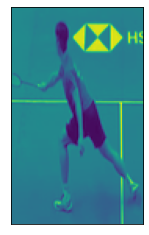

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 31ms/step
Probabilities of prediction:  [[0.02880289 0.96579826 0.00539893]]


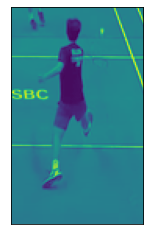

------------------------------------------------------------------
1/1 [==============================] - 0s 36ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 28ms/step
Probabilities of prediction:  [[9.8784477e-01 1.1547313e-02 6.0791505e-04]]


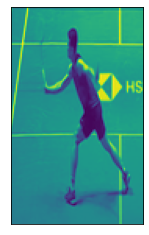

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 33ms/step
Probabilities of prediction:  [[0.03017805 0.12024914 0.84957284]]


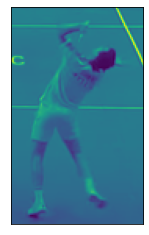

------------------------------------------------------------------
1/1 [==============================] - 0s 26ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 27ms/step
Probabilities of prediction:  [[0.84877056 0.14979821 0.00143133]]


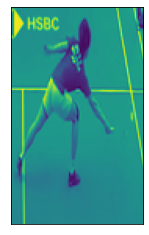

------------------------------------------------------------------
1/1 [==============================] - 0s 27ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 28ms/step
Probabilities of prediction:  [[0.26786688 0.1010958  0.63103724]]


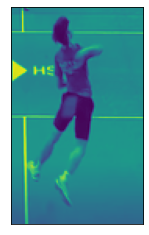

------------------------------------------------------------------
1/1 [==============================] - 0s 35ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 29ms/step
Probabilities of prediction:  [[1.1645793e-02 9.8812252e-01 2.3173149e-04]]


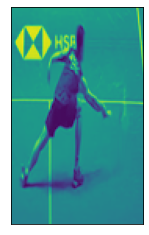

------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 27ms/step
Probabilities of prediction:  [[0.00837817 0.01253714 0.97908473]]


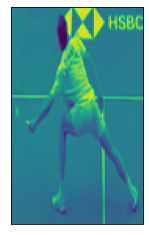

------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 35ms/step
Probabilities of prediction:  [[0.03867795 0.03918624 0.92213583]]


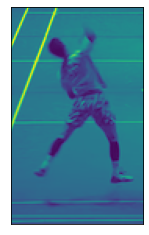

------------------------------------------------------------------
1/1 [==============================] - 0s 31ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 38ms/step
Probabilities of prediction:  [[0.00282273 0.996067   0.00111037]]


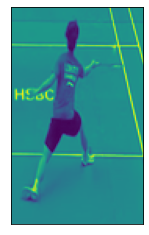

------------------------------------------------------------------
1/1 [==============================] - 0s 32ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 32ms/step
Probabilities of prediction:  [[0.03714278 0.19711117 0.765746  ]]


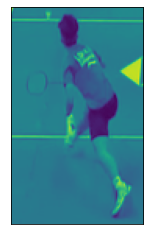

------------------------------------------------------------------
1/1 [==============================] - 0s 36ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 39ms/step
Probabilities of prediction:  [[0.44682908 0.51018465 0.04298634]]


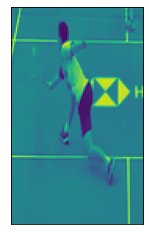

------------------------------------------------------------------
1/1 [==============================] - 0s 43ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 36ms/step
Probabilities of prediction:  [[0.00662951 0.9917868  0.00158373]]


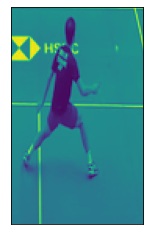

------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 33ms/step
Probabilities of prediction:  [[2.5147134e-05 1.6182764e-03 9.9835652e-01]]


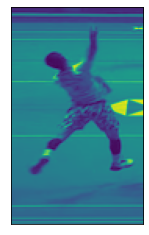

------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 31ms/step
Probabilities of prediction:  [[0.00250198 0.67113554 0.3263624 ]]


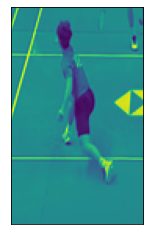

------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 32ms/step
Probabilities of prediction:  [[0.9674946  0.01478127 0.01772417]]


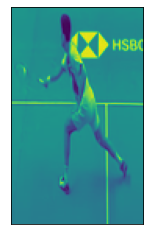

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 29ms/step
Probabilities of prediction:  [[0.00125816 0.01138419 0.9873576 ]]


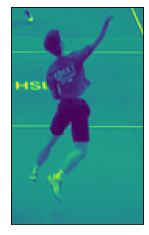

------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 29ms/step
Probabilities of prediction:  [[0.02661039 0.0182315  0.95515805]]


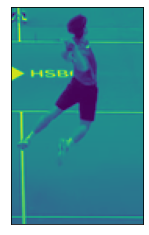

------------------------------------------------------------------
1/1 [==============================] - 0s 33ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 29ms/step
Probabilities of prediction:  [[0.02185044 0.01690497 0.96124464]]


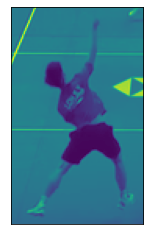

------------------------------------------------------------------
1/1 [==============================] - 0s 31ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 28ms/step
Probabilities of prediction:  [[9.5083010e-01 4.8749443e-02 4.2051225e-04]]


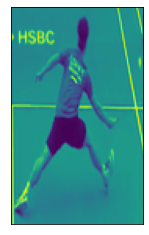

------------------------------------------------------------------
1/1 [==============================] - 0s 34ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 30ms/step
Probabilities of prediction:  [[1.6941572e-06 1.4408592e-05 9.9998391e-01]]


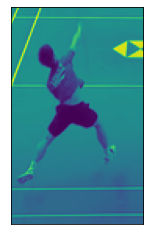

------------------------------------------------------------------
1/1 [==============================] - 0s 32ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 32ms/step
Probabilities of prediction:  [[0.6062898  0.3574073  0.03630291]]


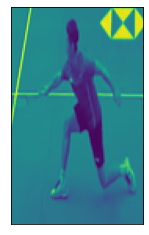

------------------------------------------------------------------
1/1 [==============================] - 0s 27ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 31ms/step
Probabilities of prediction:  [[0.13239264 0.00238009 0.8652273 ]]


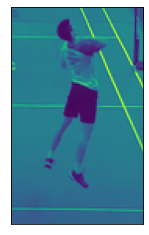

------------------------------------------------------------------
1/1 [==============================] - 0s 34ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 36ms/step
Probabilities of prediction:  [[0.6497476  0.01509615 0.33515626]]


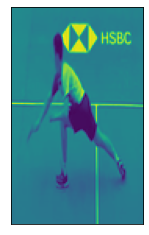

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 30ms/step
Probabilities of prediction:  [[1.0328523e-05 1.5474223e-05 9.9997425e-01]]


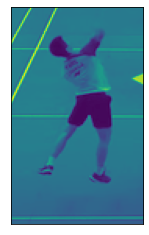

------------------------------------------------------------------
1/1 [==============================] - 0s 26ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 36ms/step
Probabilities of prediction:  [[0.08800872 0.83237475 0.07961656]]


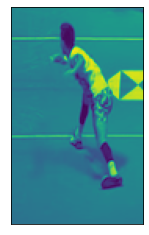

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 30ms/step
Probabilities of prediction:  [[0.01050822 0.025837   0.96365476]]


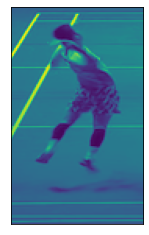

------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 35ms/step
Probabilities of prediction:  [[9.9997735e-01 1.1558611e-05 1.1125936e-05]]


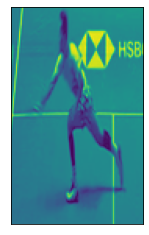

------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 31ms/step
Probabilities of prediction:  [[0.9422407  0.02529136 0.03246784]]


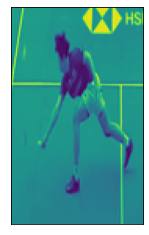

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 30ms/step
Probabilities of prediction:  [[0.04338006 0.38567483 0.57094514]]


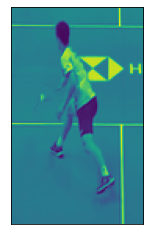

------------------------------------------------------------------
1/1 [==============================] - 0s 35ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 28ms/step
Probabilities of prediction:  [[0.01672846 0.9482064  0.03506502]]


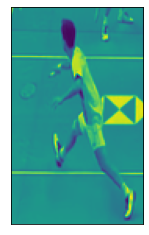

------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 31ms/step
Probabilities of prediction:  [[0.02252305 0.93957525 0.03790159]]


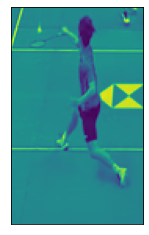

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 28ms/step
Probabilities of prediction:  [[1.10421264e-04 2.75644474e-04 9.99613941e-01]]


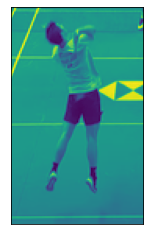

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 31ms/step
Probabilities of prediction:  [[9.9767989e-01 9.3754183e-04 1.3826033e-03]]


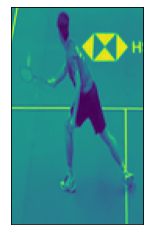

------------------------------------------------------------------
1/1 [==============================] - 0s 37ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 32ms/step
Probabilities of prediction:  [[3.0043855e-05 9.1690645e-06 9.9996078e-01]]


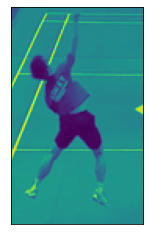

------------------------------------------------------------------
1/1 [==============================] - 0s 34ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 32ms/step
Probabilities of prediction:  [[9.9997294e-01 1.9866427e-05 7.0995134e-06]]


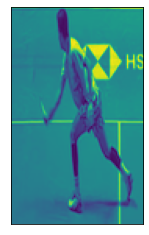

------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 27ms/step
Probabilities of prediction:  [[5.4184033e-04 5.4665465e-02 9.4479263e-01]]


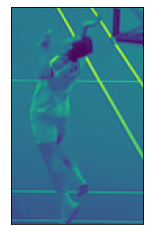

------------------------------------------------------------------
1/1 [==============================] - 0s 27ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 35ms/step
Probabilities of prediction:  [[0.01904   0.9053512 0.0756087]]


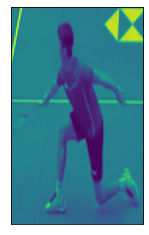

------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 28ms/step
Probabilities of prediction:  [[4.949470e-08 4.619139e-07 9.999995e-01]]


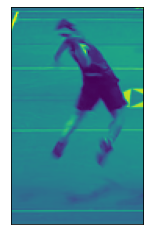

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 32ms/step
Probabilities of prediction:  [[0.21188933 0.55663145 0.23147918]]


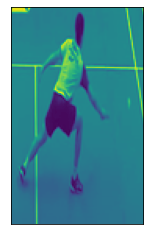

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 30ms/step
Probabilities of prediction:  [[0.01242838 0.9053377  0.08223397]]


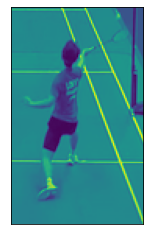

------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 36ms/step
Probabilities of prediction:  [[9.99742448e-01 1.37672003e-04 1.19866265e-04]]


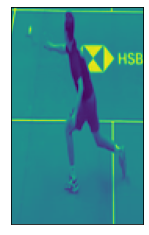

------------------------------------------------------------------
1/1 [==============================] - 0s 30ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 27ms/step
Probabilities of prediction:  [[1.9211897e-03 9.9791521e-01 1.6355531e-04]]


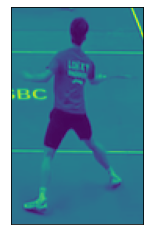

------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 44ms/step
Probabilities of prediction:  [[1.9524003e-04 5.7709254e-02 9.4209552e-01]]


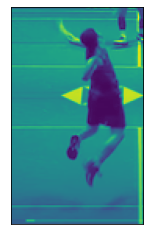

------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 34ms/step
Probabilities of prediction:  [[9.9847633e-01 7.4984337e-04 7.7385444e-04]]


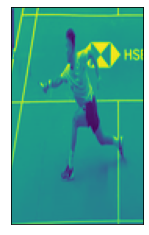

------------------------------------------------------------------
1/1 [==============================] - 0s 38ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 27ms/step
Probabilities of prediction:  [[9.9993479e-01 2.0305259e-05 4.4910976e-05]]


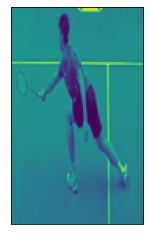

------------------------------------------------------------------
1/1 [==============================] - 0s 27ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 27ms/step
Probabilities of prediction:  [[0.16950981 0.3327823  0.49770784]]


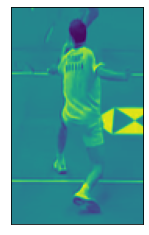

------------------------------------------------------------------
1/1 [==============================] - 0s 31ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 30ms/step
Probabilities of prediction:  [[2.5070293e-04 9.9724555e-01 2.5037846e-03]]


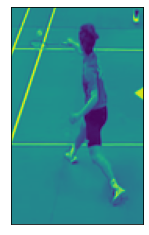

------------------------------------------------------------------
1/1 [==============================] - 0s 35ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 30ms/step
Probabilities of prediction:  [[0.8639564  0.0907923  0.04525137]]


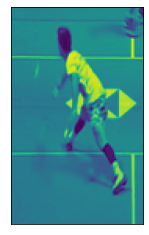

------------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 28ms/step
Probabilities of prediction:  [[9.9943680e-01 2.3762406e-04 3.2558441e-04]]


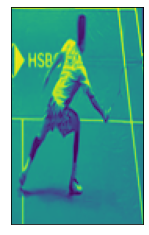

------------------------------------------------------------------
1/1 [==============================] - 0s 36ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 34ms/step
Probabilities of prediction:  [[0.5040938  0.21726723 0.27863902]]


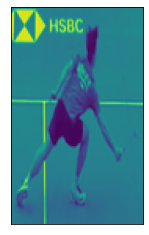

------------------------------------------------------------------
1/1 [==============================] - 0s 44ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 36ms/step
Probabilities of prediction:  [[0.00140065 0.9953472  0.00325224]]


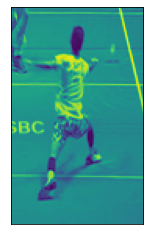

------------------------------------------------------------------
1/1 [==============================] - 0s 32ms/step
Prediction:  ['defense']
1/1 [==============================] - 0s 30ms/step
Probabilities of prediction:  [[0.98685163 0.00833716 0.00481126]]


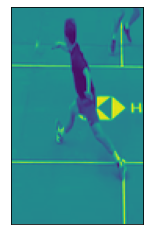

------------------------------------------------------------------
1/1 [==============================] - 0s 29ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 33ms/step
Probabilities of prediction:  [[8.6285302e-04 9.9883264e-01 3.0440761e-04]]


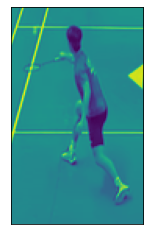

------------------------------------------------------------------
1/1 [==============================] - 0s 31ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 39ms/step
Probabilities of prediction:  [[6.965040e-10 6.909958e-09 1.000000e+00]]


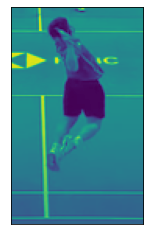

------------------------------------------------------------------
1/1 [==============================] - 0s 36ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 37ms/step
Probabilities of prediction:  [[0.13290904 0.04315066 0.82394034]]


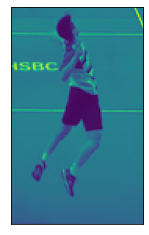

------------------------------------------------------------------
1/1 [==============================] - 0s 32ms/step
Prediction:  ['smash']
1/1 [==============================] - 0s 31ms/step
Probabilities of prediction:  [[2.9556449e-07 6.1718101e-06 9.9999356e-01]]


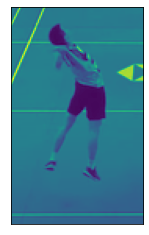

------------------------------------------------------------------
1/1 [==============================] - 0s 35ms/step
Prediction:  ['net drop return']
1/1 [==============================] - 0s 28ms/step
Probabilities of prediction:  [[0.00794851 0.9152241  0.07682741]]


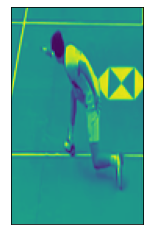

------------------------------------------------------------------


In [37]:
import matplotlib.pyplot as plt

for i in range(len(X_max_test)):
    img = X_max_test[i].reshape([1,X_max.shape[1],X_max.shape[2],1])
    prediction = model_max.predict(img).argmax()
    print('Prediction: ', le.inverse_transform([prediction]))
    print('Probabilities of prediction: ', model_max.predict(img))
    plt.imshow(tf.squeeze(X_max_test[i]))
    plt.xticks([])
    plt.yticks([])
    plt.show() 
    print('------------------------------------------------------------------')